# Fake News Detected

1. [Keşifsel Veri Analizi](#1)
1. [Veri Ön İşleme](#2)
    1. [En Sık Kullanılan Kelime Tespiti](#3)
1. [Eğitim Test Verilerinin Bölütlenmesi](#4)
1. [Metin Verilerinin Sayısal Verilere Çevrilmesi](#5)
    1. [Count Vectorizer](#6)
    1. [TFIDF Vecktorizer](#7)
1. [Model Oluşturma](#8)
    1. [Count Vectorizer ile MNB Modeli](#9)
    1. [TF-IDF Vektörü ile MNB Algoritmasının Uygulanması](#10)
    1. [Pasif Agresif Sınıflandırıcı](#11)
    1. [Logistic Regression Modelinin Oluşturulması](#12)
1. [Test Veri Setine Seçilen Modelin Uygulanması](#13)
1. [Submission](#14)

    

In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import itertools
from sklearn.metrics import classification_report

<a id="1"></a> <br>
# Keşifsel Veri Analizi

In [153]:
#concat labeled existing with internetarchive imputed missing text labeled datasets
le_data=pd.read_csv("/Users/anthonychen/Downloads/labeled_existing.csv")
le_d=le_data[['extract_text', 'label']]
print(len(le_d))
le_d.isna().sum()

25727


extract_text    3
label           0
dtype: int64

In [154]:
le_d.dropna(inplace=True)

<ipython-input-154-de3e7fe84ef9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  le_d.dropna(inplace=True)


In [155]:
# our_data=pd.read_csv("/Users/anthonychen/Downloads/text_labels.csv")
our_data=pd.read_csv("/Users/anthonychen/Downloads/merged_murltext2.csv")
our_data.drop(['Unnamed: 0'] , axis=1, inplace=True)
our_data.head()
our_data.isna().sum()

Unnamed: 0_x      0
url               0
text            516
Unnamed: 0_y      0
created_at        0
domain            0
id_hash256        0
interaction       0
num_platform      0
label             0
dtype: int64

In [156]:
print(len(our_data))
our_data.rename(columns={'text':'extract_text'}, inplace=True)
our_data.columns

13430


Index(['Unnamed: 0_x', 'url', 'extract_text', 'Unnamed: 0_y', 'created_at',
       'domain', 'id_hash256', 'interaction', 'num_platform', 'label'],
      dtype='object')

In [157]:
our_data['extract_text'].isna().sum()
len(our_data)

13430

In [158]:
our_data.dropna(inplace=True)

In [159]:
our_data.isna().sum()

Unnamed: 0_x    0
url             0
extract_text    0
Unnamed: 0_y    0
created_at      0
domain          0
id_hash256      0
interaction     0
num_platform    0
label           0
dtype: int64

In [160]:
#Use merged_murltext.csv
input_data=our_data[['extract_text', 'label']]
input_data.iloc[:,:-1]

,extract_text
0,"Corporate media is at it again, shilling for D..."
1,A report from the International Organisation f...
2,Spain passed rules that prohibit adequate cool...
3,A troubling survey commissioned by trade publi...
4,Authored by Paul Joseph Watson via Summit News...
...,...
13424,\n\nNancy Hogshead-Makar says that men should ...
13426,A New York state judge on Friday ordered the N...
13427,COVID booster: How to get a COVID-19 vaccine b...
13428,“Facing rising infections and a new COVID-19 v...


In [161]:
full_data=pd.concat([input_data, le_d], axis=0)

In [162]:
len(full_data)

38638

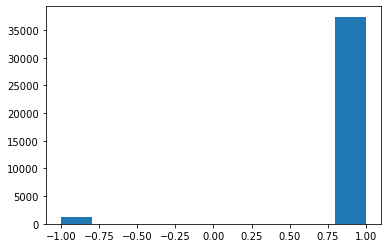

In [164]:
plt.hist(full_data.label)
plt.show()

In [165]:
full_data.columns
full_data.head()

,extract_text,label
0,"Corporate media is at it again, shilling for D...",1.0
1,A report from the International Organisation f...,1.0
2,Spain passed rules that prohibit adequate cool...,1.0
3,A troubling survey commissioned by trade publi...,1.0
4,Authored by Paul Joseph Watson via Summit News...,1.0


In [166]:
full_data['extract_text']=full_data['extract_text'].str.replace('\n','')

In [167]:
type(full_data['extract_text'][0])
full_data['extract_text'].iloc[0]

'Corporate media is at it again, shilling for Democrats. The spin heading toward Labor Day is that Republican chances of winning a Senate majority are fading. A GOP takeover of the U.S. House hangs by a thread. Nonsense. In fact, Republicans are going to win a House majority and have a good shot of doing the same in the Senate.Of course, there are no guarantees -- life is like that -- but swallowing Mitch McConnell’s trash talk is foolish. McConnell is dissing some Republican Senate candidates as low quality. Mitch is being sly.McConnell is a notorious inside player with practically zero feel for voter sentiment (McConnell went to D.C. as an intern in 1964. The Swamp is in his blood). Old Man Mitch wants a GOP caucus he can control. Add Trump-endorsed senators to the mix and McConnell may face unwanted challenges to his leadership. McConnell, like most pols, is about power and money. Mitch doesn’t want the applecart upset with more Trump loyalists in his caucus.Right-thinking Americans

In [169]:
X_train, X_test, y_train, y_test=train_test_split(full_data['extract_text'],  full_data['label'],  test_size=0.2, random_state=8)

In [170]:
len(X_train)

30910

In [171]:
X_train
X_test

7733     Texas Can’t Force Out-of-State Citizens to Pay...
6655     The Deal Has Already Been Made: DeSantis To Ru...
15501    U.S. seizes Russian oligarch’s 256-foot supery...
1640     REPORT: FBI Was After Documents Trump Believed...
5859     On June 8, 26-year-old Nicholas John Roske of ...
                               ...                        
14544    Psaki Admits Forced Masking on Planes is About...
1370     New Jersey Governor Ends Key COVID-19 Mandate ...
8807     Feds withholding info about deletion of Covid ...
15750    Good Stuff - Lynyrd Skynyrd Lead Vocalist Reco...
10955    Rep. Elise Stefanik: Nobody Cares About Januar...
Name: extract_text, Length: 7728, dtype: object

In [106]:
# train=pd.read_csv("/Users/anthonychen/Downloads/train_fnd.csv", sep='\t', encoding='utf-8')
# test = pd.read_csv("/Users/anthonychen/Downloads/test_fnd.csv", sep='\t', encoding='utf-8')
# #submission = pd.read_csv("/kaggle/input/fakenewskdd2020/sample_submission.csv")
# train.head()

In [107]:
# #nontokenized; remove new line
# train['text'][0]

Eğitim Veri Setinin Boyutu : (4987,2)

Test Veri Setinin Boyutu :  (1247, 2)

Hem eğitim hem de test veri setleri içerisinde boş(null) değer yoktur.


In [108]:
# print(f"Eğitim Verisinin Boyutu = {train.shape}")
# print(f"Test Verisinin Boyutu = {test.shape}")

In [109]:
# train.info()

In [110]:
#test.info()

In [111]:
# print(f"Eğitim Veri Seti Null Değer Kontrolü = \n {train.isnull().sum()}")
# print(f"Eğitim Veri Seti Null Değer Kontrolü = \n{test.isnull().sum()}")

Text(0.5, 1.0, 'Veri Setinin Dağılımı')

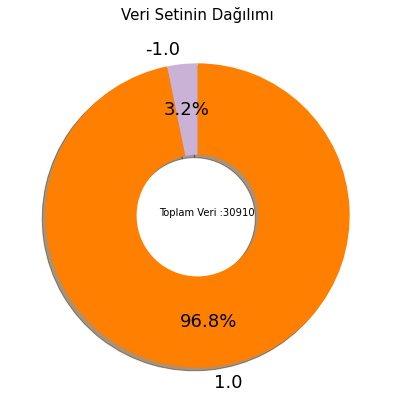

In [172]:
plt.figure(figsize=(7,7))

value_count = y_train.value_counts() #we can see there's an imbalanced dataset 


plt.pie(value_count, labels=value_count.index ,
        startangle = 90 ,counterclock =False, wedgeprops = {'width' : 0.6},
        autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 18}, 
        shadow = True,colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.25, y=0,s ="Toplam Veri :{}".format(X_train.shape[0]))
plt.title("Veri Setinin Dağılımı",size=15)


In [173]:
type(X_train)
X_train=X_train.to_frame()

<class 'list'>


(-0.5, 399.5, 199.5, -0.5)

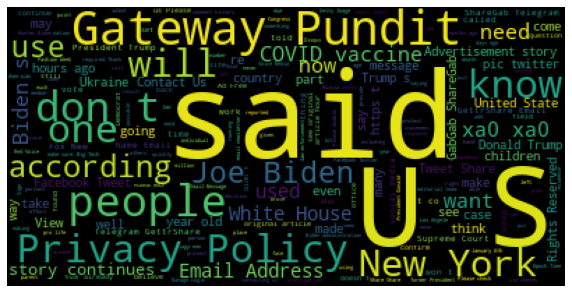

In [174]:
from wordcloud import WordCloud
#Kelime Bulutu (wordCloud) İle Veri Setinin Görselleştirilmesi

cloud = [str(x) for x in X_train.values.tolist()]
print(type(cloud))
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

In [115]:
# plt.figure(figsize=(10,6))
# plt.hist(train[train["label"]=="0"]["text"].str.len(),label="Gerçek Haber",color="red") #real news
# plt.hist(train[train["label"]=="1"]["text"].str.len(),label="Sahte Haber",color="b") #fake news
# plt.xlabel("Karakter Uzunluk",size=15)
# plt.ylabel("frekans",size=15)
# #fake news and real news by character length
# plt.title("Karakter Uzunluklarına Göre Sahte Haber ve Verçek Haberler",size=12)
# plt.legend(loc="best")
# plt.show()

In [116]:
# plt.figure(figsize=(10,6))
# plt.hist(train[train["label"]=="0"]["text"].str.split().map(lambda x: len(x)),label="Doğru Haber",color="red")   #True News
# plt.hist(train[train["label"]=="1"]["text"].str.split().map(lambda x: len(x)),label="Sahte Haber",color="b")

# plt.xlabel("Kelime Uzunluğu",size =15)
# plt.ylabel("Frekans",size=15)
# plt.title("Kelime Uzunlukluklarına Göre Verilerin Dağılımı") #Distribution of Data by Word Lengths
# plt.legend(loc="best")
# plt.show()

In [117]:
# a = train["text"].tolist()
#print(a)

Veri Setine ilk bakışta veri seti içerisinde özel karakterlerin , url'lerin ve emojilerin olduğunu gözlemliyoruz.
Veri önişleme safahasında oluşturacağımız modele negatif yönde etkileyecek bu verilerin silinmesi işlemini gerçekleştireceğiz.


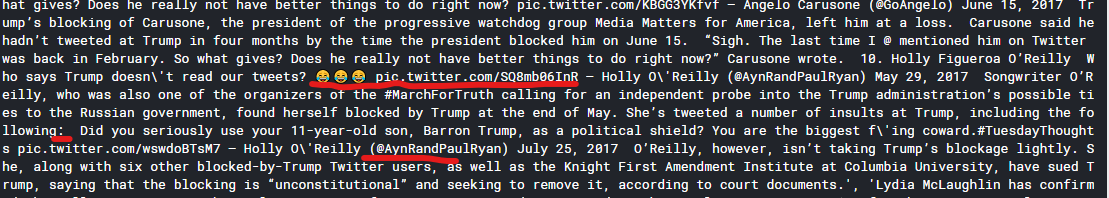

Within the information we obtain during exploratory data analysis, the data set includes; * Cleaning URLs * Clearing Special Characters and Numeric Emoticons * Conversion of characters to lowercase * Stop Words * Performing the Lemmatization Process * Deletion of Noisy Data We will carry out the operations.

<a id="2"></a> <br>
# Veri Ön İşleme

Keşifsel veri analizi sırasında elde ettiğimiz bilgilere dahilinde veri seti içerisinde bulunan ;
* URL'leri Temizleme
* Özel Karakterlerin ve Numeric İfadelerin Temizlenmesi
* Karakterlerin Küçük Harfe Çevrilmesi
* Etkisiz Kelimelerin Çıkalıması (Stop Words)
* Lematizasyon İşleminin Gerçekleştirilmesi
* Gürültülü Verilerin Silinmesi 

İşlemlerini gerçekleştireceğiz.
 #Within the information we obtain during exploratory data analysis, the data set includes; * Cleaning URLs * Clearing Special Characters and Numeric Emoticons * Conversion of characters to lowercase * Stop Words * Performing the Lemmatization Process * Deletion of Noisy Data We will carry out the operations.

In [175]:
X_train

,extract_text
2478,"Obama Caught On Video: ""You Just Have To..."" S..."
16520,Insurance Compaines Prepare To Deny Life Insur...
3780,"(Natural News) In today’s podcast, I discuss a..."
20429,Ukraine president walks back statement that Ru...
23184,EXCLUSIVE: Cyber Ninjas CEO Doug Logan Respond...
...,...
10718,President Trump endorsed Vernon Jones for Cong...
22038,WAYNE ROOT: We are in a Civil War. It’s a War ...
5503,108 ARRESTED IN CHILD TRAFFICKING STING🚨🚔 4 DI...
13027,Leaked Audio Catches Lindsey Graham Stabbing T...


In [176]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemma = WordNetLemmatizer()

def cleaning_data(text):
    text = re.sub(r'http\S+','',text)                
    #Url'lerin temizlenmesi                
    text = re.sub('[^a-zA-Z]',' ',text)              
    # Özel karakterlerin ve numarların temizlenmesi
    text = str(text).lower()                          
    #Bütün karakterlerin küçük harfe dönüşütürülmesi
    text = word_tokenize(text)                        
    #Verilerin Tokenlara ayrılması
    text = [i for i in text if i not in stop_words]   
    # Etkisiz kelimelerin çıkartılması
    text = [lemma.lemmatize(word= j, pos="v") for j in text] 
    # Lemmatizasyon işleminin gerçekleştirilmesi
    text = [k for k in text  if len(k) >2]            
    #karkater boyutu 2 den düşük olanların veri setinden atılması (gürültülü verilerin kaldırılması)
    text = " ".join(text)                             
    return text

#X_train=X_train.to_frame()
X_train["cleaning_data"] = X_train["extract_text"].apply(cleaning_data) # Bu yapıyı Test veri setinde de kullanacaksın

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonychen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anthonychen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anthonychen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [177]:
X_train

,extract_text,cleaning_data
2478,"Obama Caught On Video: ""You Just Have To..."" S...",obama catch video skip main content home get a...
16520,Insurance Compaines Prepare To Deny Life Insur...,insurance compaines prepare deny life insuranc...
3780,"(Natural News) In today’s podcast, I discuss a...",natural news today podcast discuss interview c...
20429,Ukraine president walks back statement that Ru...,ukraine president walk back statement russia a...
23184,EXCLUSIVE: Cyber Ninjas CEO Doug Logan Respond...,exclusive cyber ninjas ceo doug logan respond ...
...,...,...
10718,President Trump endorsed Vernon Jones for Cong...,president trump endorse vernon jones congress ...
22038,WAYNE ROOT: We are in a Civil War. It’s a War ...,wayne root civil war war good evil democrats c...
5503,108 ARRESTED IN CHILD TRAFFICKING STING🚨🚔 4 DI...,arrest child traffic sting disney employees ju...
13027,Leaked Audio Catches Lindsey Graham Stabbing T...,leak audio catch lindsey graham stab trump bac...


In [178]:
X_test=X_test.to_frame()
X_test["cleaning_data"] = X_test["extract_text"].apply(cleaning_data)
X_test

,extract_text,cleaning_data
7733,Texas Can’t Force Out-of-State Citizens to Pay...,texas force state citizens pay higher college ...
6655,The Deal Has Already Been Made: DeSantis To Ru...,deal already make desantis run trump accord re...
15501,U.S. seizes Russian oligarch’s 256-foot supery...,seize russian oligarch foot superyacht spain a...
1640,REPORT: FBI Was After Documents Trump Believed...,report fbi document trump believe would exoner...
5859,"On June 8, 26-year-old Nicholas John Roske of ...",june year old nicholas john roske california c...
...,...,...
14544,Psaki Admits Forced Masking on Planes is About...,psaki admit force mask plan preserve power vid...
1370,New Jersey Governor Ends Key COVID-19 Mandate ...,new jersey governor end key covid mandate unva...
8807,Feds withholding info about deletion of Covid ...,feds withhold info deletion covid genetic data...
15750,Good Stuff - Lynyrd Skynyrd Lead Vocalist Reco...,good stuff lynyrd skynyrd lead vocalist record...


In [122]:
# X_test=X_test.to_frame()
# X_test["cleaning_data"] = X_test["extract_text"].apply(cleaning_data) 

In [179]:
X_train.shape
X_test.shape

(7728, 2)

In [180]:
X_train.head(20)
X_test.head(20)

,extract_text,cleaning_data
7733,Texas Can’t Force Out-of-State Citizens to Pay...,texas force state citizens pay higher college ...
6655,The Deal Has Already Been Made: DeSantis To Ru...,deal already make desantis run trump accord re...
15501,U.S. seizes Russian oligarch’s 256-foot supery...,seize russian oligarch foot superyacht spain a...
1640,REPORT: FBI Was After Documents Trump Believed...,report fbi document trump believe would exoner...
5859,"On June 8, 26-year-old Nicholas John Roske of ...",june year old nicholas john roske california c...
22583,BOMBSHELL! “Premeditated Manslaughter of Milli...,bombshell premeditate manslaughter millions pe...
2788,Canadian Public Bank Kept Secret Blacklist of ...,canadian public bank keep secret blacklist cus...
16407,Anti-Democrat Biden Insinuates He Hates Politi...,anti democrat biden insinuate hat political co...
3174,On Thursday the Kremlin responded to US Secret...,thursday kremlin respond secretary state anton...
9273,Who did this??ðŸ˜‚ðŸ˜‚ðŸ˜‚ Who did this??ðŸ˜‚ð...,donaldo trumpo publish july view subscribe joi...


<a id="3"></a> <br>
## En Sık Kullanılan Kelime Tespiti

Sahte haber ve Gerçek haberlerin verilerine bakılarak her iki veri sınıfında en çok tekrar eden ortak kelimelerin tespit edilip veri setinden çıkarma işlemi gerçekleştirdik.

By looking at the data of fake news and real news, we identified the most repeated common words in both data classes and removed them from the data set.

In [181]:
y_train.unique()

array([ 1., -1.])

In [182]:
train=pd.concat([X_train, y_train], axis=1)
test=pd.concat([X_test,  y_test], axis=1)
train.head()
test.head()

,extract_text,cleaning_data,label
7733,Texas Can’t Force Out-of-State Citizens to Pay...,texas force state citizens pay higher college ...,1.0
6655,The Deal Has Already Been Made: DeSantis To Ru...,deal already make desantis run trump accord re...,1.0
15501,U.S. seizes Russian oligarch’s 256-foot supery...,seize russian oligarch foot superyacht spain a...,-1.0
1640,REPORT: FBI Was After Documents Trump Believed...,report fbi document trump believe would exoner...,1.0
5859,"On June 8, 26-year-old Nicholas John Roske of ...",june year old nicholas john roske california c...,1.0


In [183]:
train.dtypes

extract_text      object
cleaning_data     object
label            float64
dtype: object

<ipython-input-184-b3cc5486bad6>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gercek_haber = train[train["label"] == np.float(1.0)]["cleaning_data"]
<ipython-input-184-b3cc5486bad6>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sahte_haber = train[train["label"] == np.float(-1.0)]["cleaning_data"]


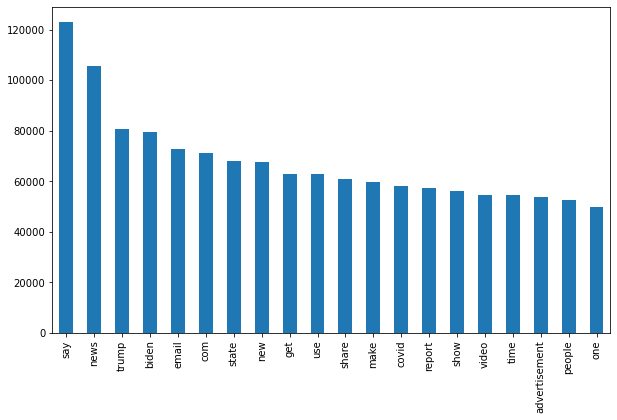

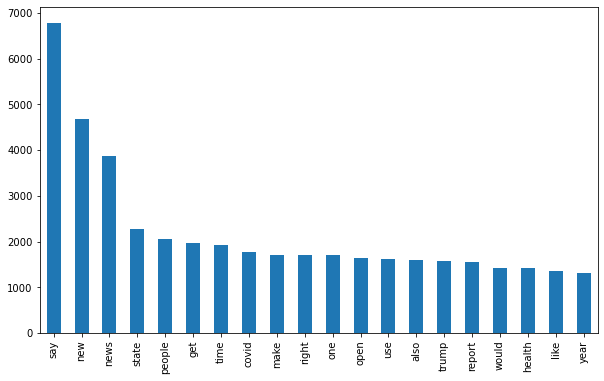

In [184]:
gercek_haber = train[train["label"] == np.float(1.0)]["cleaning_data"]
sahte_haber = train[train["label"] == np.float(-1.0)]["cleaning_data"]
df = [gercek_haber,sahte_haber]

for i in range(2):
    plt.figure(figsize=(10,6))
    pd.Series(' '.join([j for j in df[i]]).split()).value_counts().head(20).plot(kind="bar")
    plt.show()

Hem Sahte haber hem de gerçek haberde en çok tekrar eden kelime "say" kelimesidir. Modelimizin daha iyi bir performansa sahip olması için "say" kelimesini veri setinden temizleme işlemi gerçekleştiriyoruz.

The most recurring word in both fake news and real news is "say." We remove the word "count" from the data set so that our model has better performance.

In [185]:
#removal of common word say; same as our data
def kelime_sil(text):
    return ' '.join([i for i in text.split() if i !="say"])
train["cleaning_data"] = train["extract_text"].apply(cleaning_data)
train["clean"] = train["cleaning_data"].apply(kelime_sil)

test["cleaning_data"] = test["extract_text"].apply(cleaning_data)
test["clean"] = test["cleaning_data"].apply(kelime_sil)

In [186]:
#İhtiyacımız olmayan kolonların temizlenmesi
train.drop(["extract_text","cleaning_data"],axis=1,inplace=True)
train.head()

,label,clean
2478,1.0,obama catch video skip main content home get a...
16520,1.0,insurance compaines prepare deny life insuranc...
3780,1.0,natural news today podcast discuss interview c...
20429,1.0,ukraine president walk back statement russia a...
23184,1.0,exclusive cyber ninjas ceo doug logan respond ...


In [187]:
test.drop(["extract_text","cleaning_data"],axis=1,inplace=True)
test.head()

,label,clean
7733,1.0,texas force state citizens pay higher college ...
6655,1.0,deal already make desantis run trump accord re...
15501,-1.0,seize russian oligarch foot superyacht spain a...
1640,1.0,report fbi document trump believe would exoner...
5859,1.0,june year old nicholas john roske california c...


<a id="4"></a> <br>
# Model Oluşturma

In [132]:
# train=pd.read_csv("/Users/anthonychen/Downloads/train_fnd.csv", sep='\t', encoding='utf-8')
# test = pd.read_csv("/Users/anthonychen/Downloads/test_fnd.csv", sep='\t', encoding='utf-8')

In [134]:
#np.all(y_train == train.label.to_frame())

In [ ]:
# x = train["clean"]  
# # Tahmin edilecek girdi verilerini x değişkenine.
# y = train ["label"] 
# # Hedef ddeğişkenimiz olan "label" özniteliğini y değişkenine atadık.

# #create a validation set train, test split
# X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=18)
# # Modelin eğitimi için verilerin %80'ini eğitime %20 sini test verileri olarak bölme işlemi gerçekleştirdim.

# print(f"X_train Boyutu : {X_train.shape}")
# print(f"X_test Boyutu : {X_test.shape}")
# print(f"y_train Boyutu : {y_train.shape}")
# print(f"y_test Boyutu : {y_test.shape}")

In [188]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english') 
# Eğitim verilerin fit edilmesi .
count_train = count_vectorizer.fit_transform(train['clean'])
# Test verilerin fit edilmesi
count_test = count_vectorizer.transform(test['clean'])

In [189]:
count_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

<a id="5"></a> <br>
# Metin Verilerinin Sayısal Verilere Dönüştürülmesi

<a id="6"></a> <br>
### Count Vectorizer

In [ ]:
#X_train.head(2)

In [ ]:
#X_train

In [190]:
# Count Vectorize(Sayma Vektörü)
#adjust max_features 100, 500, 1000

count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=100) 
# Eğitim verilerin fit edilmesi .
count_train = count_vectorizer.fit_transform(train['clean'])
# Test verilerin fit edilmesi
count_test = count_vectorizer.transform(test['clean'])

In [191]:
#high number of words; maybe reduce infrequent words
count_train.shape

(30910, 100)

<a id="7"></a> <br>
### TF-IDF Vecktorizer

In [192]:
#Tf-IDF Vektörizasyonu

tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=100)
#Eğitim Verisinin  Tf-Idf Dönüştürülmesi
tfidf_train = tfidf_vectorizer.fit_transform(train['clean'])
#Test Verilerinin Tf-Idf Dönüştürülmesi 
tfidf_test = tfidf_vectorizer.transform(test['clean'])


In [193]:
tfidf_train.shape

(30910, 100)

<a id="8"></a> <br>
# Model Oluşturma

<a id="9"></a> <br>

## Count Vectorizer ile MNB Modeli

In [194]:
count_train.getnnz()

1160139

In [195]:
count_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 4, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 1],
        ...,
        [0, 1, 4, ..., 0, 0, 0],
        [0, 3, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 0, 1]])

In [196]:
# Count Vectorizer metodu ile Multinomial Naive Bayes algoritmasının uygulanması 
nb_classifier = MultinomialNB(alpha = 0.1)
#MNB algoritmasının eğitilmesi
nb_classifier.fit(count_train, train.label)
#MNB algoritmasının predict edilmesi
pred_nb_count = nb_classifier.predict(count_test)
#Doğruluk metriğinin hesaplanması
acc_nb_count = metrics.accuracy_score(test.label, pred_nb_count)
#round ile elde edilen sonucun yüzelik olarak yazdırılması
print(f"Count Vectorizer MNB Modelinin Accuracy Başarımı = %{round(acc_nb_count*100,2)}")
print(f" = {classification_report(test.label,pred_nb_count)}")

#check AUC 
#print(pred_nb_count)
#print(y_test)
pred_nb_count=np.array([int(i) for i in pred_nb_count])
print('AUC:', metrics.roc_auc_score(test.label, pred_nb_count))

Count Vectorizer MNB Modelinin Accuracy Başarımı = %73.68
 =               precision    recall  f1-score   support

        -1.0       0.09      0.72      0.15       255
         1.0       0.99      0.74      0.84      7473

    accuracy                           0.74      7728
   macro avg       0.54      0.73      0.50      7728
weighted avg       0.96      0.74      0.82      7728

AUC: 0.727550948119111


In [197]:
# MNB için hiperparametrenin belirlenmesi
for alpha in np.arange(0,1,.05):
    nb_classifier_hp = MultinomialNB(alpha=alpha)
    nb_classifier_hp.fit(count_train, train.label)
    pred_hp = nb_classifier_hp.predict(count_test)
    score = metrics.accuracy_score(test.label, pred_hp)
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))


Alpha: 0.00 Score: 0.73706
Alpha: 0.05 Score: 0.73680
Alpha: 0.10 Score: 0.73680
Alpha: 0.15 Score: 0.73680
Alpha: 0.20 Score: 0.73680
Alpha: 0.25 Score: 0.73680


/Users/anthonychen/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Alpha: 0.30 Score: 0.73680
Alpha: 0.35 Score: 0.73680
Alpha: 0.40 Score: 0.73680
Alpha: 0.45 Score: 0.73680
Alpha: 0.50 Score: 0.73680
Alpha: 0.55 Score: 0.73680
Alpha: 0.60 Score: 0.73680
Alpha: 0.65 Score: 0.73680
Alpha: 0.70 Score: 0.73680
Alpha: 0.75 Score: 0.73680
Alpha: 0.80 Score: 0.73680
Alpha: 0.85 Score: 0.73680
Alpha: 0.90 Score: 0.73680
Alpha: 0.95 Score: 0.73680


Original: Alpha: 0.90 Score: 0.77355

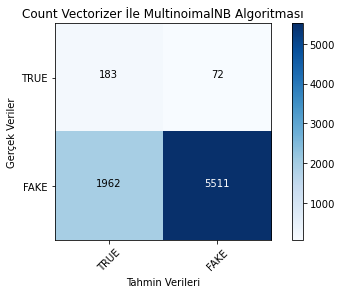

In [198]:
# Alpha Değeri 0.90 olarak MNB modelinin uygulanması
nb_classifier = MultinomialNB(alpha = 0.90)
nb_classifier.fit(count_train, train.label)
pred_nb_count = nb_classifier.predict(count_test)
cm = metrics.confusion_matrix(test.label, pred_nb_count)

# Confusion Matrisinin Oluşturulması ve ileride kullanılacak modellere uygulanabilmesi için confusion matris fonksiyounun oluşuturlması
def plot_confusion_matrix(cm, classes,
                          #cm = eğitlen modelin CF metrikleri , Classes= True,Fake olmak üzere sahte haberlerin sınıf değerleri
                          normalize=False,
                          # Grafiğimizin Başlığı
                          title='Confusion matrix', 
                          #Grafiğimizin Renkleri
                          cmap=plt.cm.Blues):       
    #Grafiğin imshow metodu ile çizilmesi
    plt.imshow(cm, cmap=cmap) 
    #Grafik Başlığı
    plt.title(title)          
    plt.colorbar()            
    tick_marks = np.arange(len(classes))
    # xekseninkide "True-False" sınıflarının yazdırılması
    plt.xticks(tick_marks, classes, rotation=45)
    # yekseninkide "True-False" sınıflarının yazdırılması
    plt.yticks(tick_marks, classes)              
    thresh = cm.max() / 2                        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 #kutucukların merkezine konumlandırma
                 horizontalalignment="center",   
                 #TN değerini beyaz fontta yazdırma
                 color="white" if cm[i, j] > thresh else "black") 

    plt.tight_layout()
    plt.ylabel('Gerçek Veriler')
    plt.xlabel('Tahmin Verileri')
    
    
plot_confusion_matrix(cm, classes=['TRUE','FAKE'], title ='Count Vectorizer İle MultinoimalNB Algoritması')

<a id="10"></a> <br>

## TF-IDF Vektörü ile MNB Algoritmasının Uygulanması

In [199]:
#TF-IDF Vektörü ile MNB Algoritmasının Uygulanması

nb_classifier = MultinomialNB(alpha = 0.1)                   
#MNB algoritmasının değişkene atanması
nb_classifier.fit(tfidf_train, train.label)                      
#Mnb algoritması ile verilerin eğitilmesi
pred_nb_tfidf = nb_classifier.predict(tfidf_test)            
#tahminleme Prediction işleminin gerçekleştirilmesi
acc_nb_tfidf = metrics.accuracy_score(test.label, pred_nb_tfidf) 
#doğruluk metriğinin hesaplanması
print(f"Accuracu = %{round(acc_nb_tfidf*100,2)}")  
print(f" = {classification_report(test.label,pred_nb_tfidf)}")
#doğruluk metriğinin yazdırılması

pred_nb_tfidf=np.array([int(i) for i in pred_nb_tfidf])
print('AUC:', metrics.roc_auc_score(test.label, pred_nb_tfidf))


Accuracu = %96.7
 =               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       255
         1.0       0.97      1.00      0.98      7473

    accuracy                           0.97      7728
   macro avg       0.48      0.50      0.49      7728
weighted avg       0.94      0.97      0.95      7728

AUC: 0.5


/Users/anthonychen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [200]:
#TF-IDf yöntemi ile gerçekleştirdiğimiz modelin hiper parametresini ayarlama
for alpha in np.arange(0,0.1,.01): 
    nb_classifier_tune = MultinomialNB(alpha=alpha)            
    #döngü içerisindeki arttırım sayısına göre modelin alpha değerinin girilmesi 
    nb_classifier_tune.fit(tfidf_train, train.label)               
    #Modelin eğitilmesi
    pred_tune = nb_classifier_tune.predict(tfidf_test)         
    #tahminleme prediction işleminingeröekleştirilmesi
    score = metrics.accuracy_score(test.label, pred_tune)          
    #doğruluk metriğinin hesaplanması
    print("Alpha: {:.2f}  Score: {:.5f}".format(alpha, score)) 
    #elde edilen sonucun yazdırılması

Alpha: 0.00  Score: 0.96700
Alpha: 0.01  Score: 0.96700
Alpha: 0.02  Score: 0.96700
Alpha: 0.03  Score: 0.96700
Alpha: 0.04  Score: 0.96700
Alpha: 0.05  Score: 0.96700
Alpha: 0.06  Score: 0.96700
Alpha: 0.07  Score: 0.96700
Alpha: 0.08  Score: 0.96700


/Users/anthonychen/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Alpha: 0.09  Score: 0.96700


Hiperparametre seçiçinde en yüksek başarımı sağlayan Alpha: Alpha: 0.04  Score: 0.78156 değeridir bunu seçerek modelimi tekrar oluşturup confusion matrisini oluşturacağım

0.9670031055900621
 =               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       255
         1.0       0.97      1.00      0.98      7473

    accuracy                           0.97      7728
   macro avg       0.48      0.50      0.49      7728
weighted avg       0.94      0.97      0.95      7728



/Users/anthonychen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


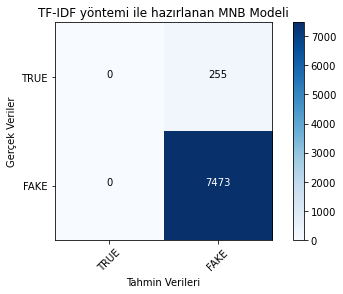

In [201]:
nb_classifier = MultinomialNB(alpha = 0.04)
nb_classifier.fit(tfidf_train, train.label)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
cm2 = metrics.confusion_matrix(test.label, pred_nb_tfidf)
print(metrics.accuracy_score(test.label, pred_nb_tfidf))
print(f" = {classification_report(test.label,pred_nb_tfidf)}")
plot_confusion_matrix(cm2, classes=['TRUE','FAKE'],title ='TF-IDF yöntemi ile hazırlanan MNB Modeli')

<a id="11"></a> <br>

## Pasif Agresif Sınıflandırıcı

Accuracy = %96.78
 =               precision    recall  f1-score   support

        -1.0       1.00      0.02      0.05       255
         1.0       0.97      1.00      0.98      7473

    accuracy                           0.97      7728
   macro avg       0.98      0.51      0.51      7728
weighted avg       0.97      0.97      0.95      7728

AUC: 0.5117647058823529


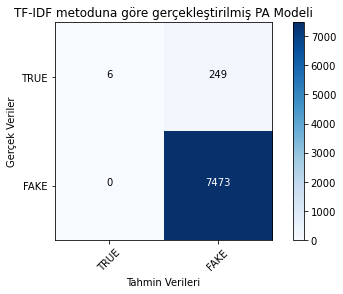

In [202]:
# TF-IDF metodu ile sayısallaştırılmış veriler ile Pasif Agresif Sınıflandırıcının uygulanması
linear_classifier = PassiveAggressiveClassifier(C=0.5,random_state=5)                    
#PA sınıflandırıcının çağırlması
linear_classifier=linear_classifier.fit(tfidf_train, y_train)        
#eğitim seti içerisinde eğitimin gerçekleştrilmesi
pred_linear_tfidf = linear_classifier.predict(tfidf_test)            
#tahminleme prediction işleminin gerçekleştirilmesi
acc_linear_tfidf = metrics.accuracy_score(y_test, pred_linear_tfidf) 
#Doğruluk değerinin hesaplanması
print(f"Accuracy = %{round(acc_linear_tfidf*100,2)}")                
#Doğruluk değerinin girilmesi
cm5 = metrics.confusion_matrix(y_test, pred_linear_tfidf) 
print(f" = {classification_report(y_test, pred_linear_tfidf)}")
#Confusion matrisi metriklerinin hesaplanması
plot_confusion_matrix(cm5, classes=['TRUE','FAKE'], title ='TF-IDF metoduna göre gerçekleştirilmiş PA Modeli')

pred_linear_tfidf=np.array([int(i) for i in pred_linear_tfidf])
print('AUC:', metrics.roc_auc_score(y_test, pred_linear_tfidf))

<a id="12"></a> <br>

## Logistic Regression Modelinin Oluşturulması

In [203]:
trigram_vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,3))

classifier = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

accuracy: %98.6
              precision    recall  f1-score   support

        -1.0       0.99      0.58      0.73       255
         1.0       0.99      1.00      0.99      7473

    accuracy                           0.99      7728
   macro avg       0.99      0.79      0.86      7728
weighted avg       0.99      0.99      0.98      7728



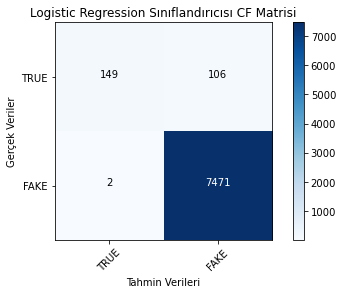

In [204]:
pipe = Pipeline([('vect', CountVectorizer(analyzer = "word", ngram_range=(1,3))),
                 ('tfidf', TfidfTransformer(norm="l2")),
                 ('model', classifier)
                  ])
# modelin eğitilmesi
model = pipe.fit(train.clean, train.label)
# tahminleme Prediction işleminin gerçekleştirilmesi
prediction = model.predict(test.clean)
#doğruluk başarımının ekrana yazılması
print(f"accuracy: %{round(accuracy_score(test.label, prediction)*100,2)}")
print(f"{classification_report(test.label, prediction)}")
#Confusion matrisini oluşturma
cm5 = metrics.confusion_matrix(test.label, prediction)
plot_confusion_matrix(cm5, classes=['TRUE','FAKE'], title ='Logistic Regression Sınıflandırıcısı CF Matrisi')

Uygulamış olduğum modeller arasında en yüksek doğruluk ve en yüksek F-1 Skor değerlerini veren model Logistic Regression modeli olduğu için test veri seti içerisinde bu modelimle tahminleme işlemini gerçekleştirip submission'umu gerçekleştireceğim.

<a id="13"></a> <br>

# Test Veri Setine Seçilen Modelin Uygulanması

In [ ]:
# Test Verisini Oluşturuduğumuz Veri Ön İşleme Fonskyionundan Geçiriyoruz.
# test["text"] = test["text"].apply(cleaning_data)

In [ ]:
# Modelimizi Test Veri Setinde Tahminleme İşlemini Gerçekleştiriyoruz.
# test_pred = model.predict(test["text"])

In [ ]:
# #Test Veri Setine "Label" Adlı Hedef Özniteliğimizi Oluşturup İçerisine Elde Ettiğimiz Sonucu Yazıyoruz.
# test['label'] = test_pred
# test.head()

# #Oluşturduğumuz Öznitelik İçeriindeki Değerleri Value_Count Metodu İle Dağılımını Gözlemliyoruz
# print(test["label"].value_counts())


0        815
1        431
label      1
Name: label, dtype: int64


<a id="14"></a> <br>

# Submission

In [ ]:
# sub_test = test[['id','label']]

In [ ]:
# sub_test.to_csv("first_sub.csv",index = False)
# from IPython.display import FileLink
# FileLink(r'first_sub.csv')

/kaggle/working/first_sub.csv